# <center> Systematic Trading Strategies with Machine Learning Algorithms </center>

## <center>Programming Session 5 - Enhancing Strategy Performance in Crypto Markets
</center>
<center>
<table class="tfo-notebook-buttons" style="margin-left: auto; margin-right: auto;">
  <tr>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://hm-ai.github.io/Systematic_Trading_Strategies_with_Machine_Learning_Algorithms/">
        <img src="https://drive.google.com/uc?export=view&id=1hTIoxoea8RTLgKb1oE6_PFmtTNPGs5p4" height="50"/>
        <br>Course page
      </a>
    </td>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://colab.research.google.com/drive/1ShvopMV15VqO-wvivlV5eEc1q8q5xQEi?usp=sharing">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />
        <br>Run in Google Colab
      </a>
    </td>
  </tr>
</table>
</center>

* This programming session is part of the "Systematic Trading with Machine Learning Algorithm" module, where we implement two essential components for algorithmic trading in cryptocurrency markets.


* Our first objective is to implement the Trend Scanning Method for labeling Bitcoin price data. This technique identifies meaningful price trends by scanning multiple time horizons and detecting statistically significant movements, providing superior training labels compared to fixed-threshold approaches. We will work through the mathematical framework and code implementation to generate labels that capture the dynamic nature of cryptocurrency price movements.

* Our second objective is to develop a metamodel that filters trading signals from a primary model. We will train Random Forest, XGBoost, and Neural Network classifiers using features derived from market microstructure, including momentum indicators, volatility measures, and autocorrelation patterns. Through systematic evaluation, we will compare model performance and implement feature importance analysis to understand which market conditions most influence signal reliability.


<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1RHsxonTrnMFl1h0dSB_zr6CB2cxQLQkW"></center>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm1
import warnings
warnings.filterwarnings('ignore')

# Getting the Data

In [ ]:
urls = {
    'prices': 'https://drive.google.com/uc?id=1P_5ykYLd5521QUdCxC_cMytdJ3PqESTw',
    'X_train': 'https://drive.google.com/uc?id=1-TYh3Sq29Yh3aCVqBBcG3GMQEw7qcIIp',
    'X_test': 'https://drive.google.com/uc?id=1-RURCLc4YxTcIfFwmtB19oI63-m9CAAY',
    'y_train': 'https://drive.google.com/uc?id=1-NT7nwC6UhtYh970KbzVrHvVZEBLeBFf',
    'y_test': 'https://drive.google.com/uc?id=1-Ksh27G0vcSXtWJ8CftGVr0AqO1eeLLg',
}

In [ ]:
def load_crypto_data_from_dict(urls):
    """
    Load cryptocurrency datasets from a dictionary of URLs.

    Args:
        urls: Dictionary mapping file names to their URLs
    """
    try:
        data = {}

        # Load each file
        print("\nLoading datasets...")

        # Prices
        print("Loading prices data...")
        data['prices'] = pd.read_csv(urls.get('prices'))
        data['prices']['date'] = pd.to_datetime(data['prices']['date'])
        print("✓ Loaded prices")

        # Training features
        print("Loading training feature matrix X_train...")
        data['X_train'] = pd.read_csv(urls.get('X_train'), index_col=0)
        print("✓ Loaded X_train")

        # Training labels
        print("Loading training labels y_train...")
        data['y_train'] = pd.read_csv(urls.get('y_train'), index_col=0)
        print("✓ Loaded y_train")

        # Test features
        print("Loading test feature matrix X_test...")
        data['X_test'] = pd.read_csv(urls.get('X_test'), index_col=0)
        print("✓ Loaded X_test")

        # Test labels
        print("Loading test labels y_test...")
        data['y_test'] = pd.read_csv(urls.get('y_test'), index_col=0)
        print("✓ Loaded y_test")


        print("\nAll data loaded successfully! 🎉")
        return data

    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [ ]:
data = load_crypto_data_from_dict(urls)


Loading datasets...
Loading prices data...
✓ Loaded prices
Loading training feature matrix X_train...
✓ Loaded X_train
Loading training labels y_train...
✓ Loaded y_train
Loading test feature matrix X_test...
✓ Loaded X_test
Loading test labels y_test...
✓ Loaded y_test

All data loaded successfully! 🎉


<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/2C5zWGX2LoLoF9YN7">Click here to participate in the poll</a>👈👈</center>

# Labeling Data using Trend Scanning Method

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1D_1x99k4z6LReXqOw2JmLSlf90Beyeil"></center>


---
<font color=green>Q1:</font> <br><font color='green'>
Create a new DataFrame called `price_data` by extracting the 'prices' DataFrame from the main data dictionary and setting the 'date' column as the index.
**Expected:**
- Input: `data` dictionary containing a 'prices' DataFrame
- Output: A DataFrame with the date column as the index
</font>

---

In [ ]:
# Load the data
price_data = data['prices'].set_index('date')

In [ ]:
price_data

,coin,open,high,low,close,volume
date,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753
...,...,...,...,...,...,...
2024-03-20 12:00:00,BTC,63432.0,63995.7,63211.5,63701.9,6191.443000
2024-03-20 13:00:00,BTC,64101.7,64107.1,63734.0,63764.1,2625.228000
2024-03-20 14:00:00,BTC,63640.6,63918.0,63487.3,63865.9,3102.018000


---
<font color=green>Q2:</font> <br><font color='green'>
Filter the price data to extract Bitcoin closing prices for the year 2021. Display summary statistics including the number of records, date range, price range, and show the first and last 5 entries of the filtered data.
**Expected:**
- Input: `price_data` DataFrame with datetime index and a 'close' column
- Output: A Series containing BTC closing prices for 2021 with printed summary information
</font>

---

In [ ]:
# Filter the data
btc_2021 = price_data.loc['2021', 'close']
print("BTC Price Data for 2021:")
print(f"Number of records: {len(btc_2021)}")
print(f"Date range: {btc_2021.index.min()} to {btc_2021.index.max()}")
print(f"Price range: ${btc_2021.min():.2f} - ${btc_2021.max():.2f}")
print("\nFirst 5 entries:")
print(btc_2021.head())
print("\nLast 5 entries:")
print(btc_2021.tail())

BTC Price Data for 2021:
Number of records: 8760
Date range: 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Price range: $28882.61 - $68634.49

First 5 entries:
date
2021-01-01 00:00:00    28882.61
2021-01-01 01:00:00    29140.18
2021-01-01 02:00:00    29412.88
2021-01-01 03:00:00    29298.79
2021-01-01 04:00:00    29333.71
Name: close, dtype: float64

Last 5 entries:
date
2021-12-31 19:00:00    46534.23
2021-12-31 20:00:00    46062.94
2021-12-31 21:00:00    45875.98
2021-12-31 22:00:00    46434.43
2021-12-31 23:00:00    46423.44
Name: close, dtype: float64


---
<font color=green>Q3:</font> <br><font color='green'>
Extract Bitcoin closing prices for 2021 from the price data and create a line plot visualization of the daily closing prices throughout the year.
**Expected:**
- Input: `price_data` DataFrame with datetime index and a 'close' column
- Output: A line chart showing Bitcoin price evolution during 2021 with appropriate labels and formatting
</font>

---

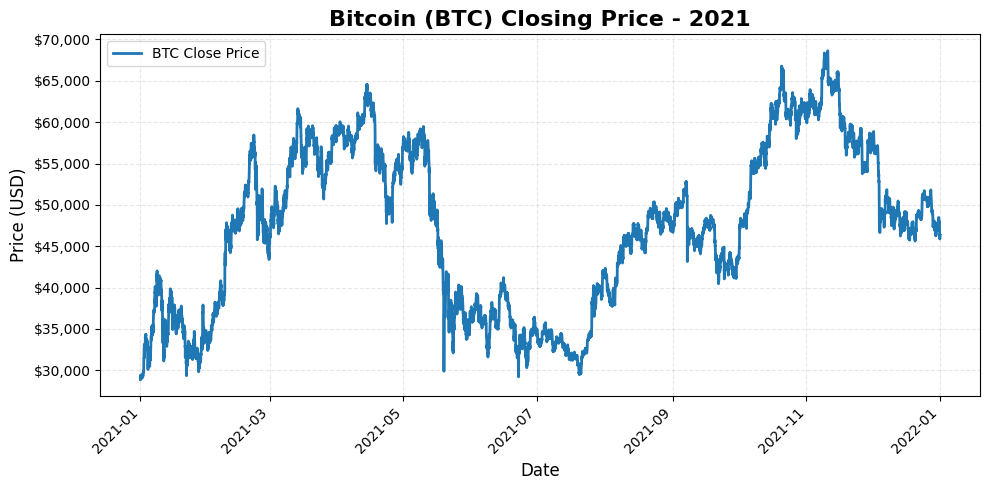

In [ ]:
# Get the
btc_2021 = price_data[["close"]].loc["2021"]

# Create the visualization
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the closing price
ax.plot(btc_2021.index, btc_2021['close'],
        linewidth=2, color='#1f77b4', label='BTC Close Price')

# Formatting
ax.set_title('Bitcoin (BTC) Closing Price - 2021', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)

# Format y-axis to show dollar values
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

# Add legend
ax.legend(loc='best')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/2C5zWGX2LoLoF9YN7">Click here to participate in the poll</a>👈👈</center>

### Labeling the BTC price data using Trend Scanning Method

---
<font color=green>Q4:</font> <br><font color='green'>
Implement two functions for the Trend Scanning Method and apply them to Bitcoin price data for 2021. First, create a function `tValLinR` that performs linear regression on a time series to extract the slope's t-value. Second, create a function `trend_labels` that identifies significant trends by scanning multiple time horizons and selecting the one with the highest absolute t-value. Finally, apply these functions to 2021 Bitcoin closing prices and visualize the results.
* **Function 1: `tValLinR`**
  - Input: `close` - pandas Series of closing prices (any length)
  - Process: Performs OLS regression with time as independent variable
  - Output: Tuple of (t-value of slope coefficient as float, regression parameters as array)
* **Function 2: `trend_labels`**
  - Input:
    - `price_series`: pandas Series with datetime or integer index
    - `observation_span`: tuple of (min_periods, max_periods) defining window range to scan
    - `look_forward`: boolean, if True analyzes forward trends, if False analyzes backward trends
  - Process: For each point, tests all window sizes in the range and selects the one with maximum absolute t-value
  - Output: DataFrame with same index as input containing:
    - `t1`: datetime/index of window end point
    - `tVal`: t-value of the trend (capped at ±20 or variance threshold)
    - `bin`: trend direction as -1, 0, or 1 (sign of t-value)
    - `windowSize`: selected window length as integer

**Final step**: Apply to Bitcoin 2021 data with windows 5-20 periods and create a scatter plot visualization with points colored by t-values
</font>

---

In [ ]:
def tValLinR(close):
    """
    Calculate the t-value and coefficients of the slope from a linear regression of the time series.

    Parameters:
    - close (pd.Series): A pandas series of closing prices.

    Returns:
    - tuple: (t-value of the slope coefficient, coefficients of the regression)
    """
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sm1.OLS(close, x).fit()
    return ols.tvalues[1], ols.params

In [ ]:
def trend_labels(price_series, observation_span, look_forward=True):
    """
    Generate labels for segments of a time series based on the trend (slope) over a specified observation span.

    Parameters:
    - price_series (pd.Series): A pandas series of prices or any numerical values, indexed by dates or integers.
    - observation_span (tuple): A tuple (min_value, max_value) defining the range of observation periods.
    - look_forward (bool): If True, the function analyzes forward trends. If False, it analyzes backward trends.

    Returns:
    - pd.DataFrame: A DataFrame with columns ['t1', 'tVal', 'bin', 'windowSize'].
    """
    # Initialize a DataFrame to store the results with the same index as the price_series
    out = pd.DataFrame(index=price_series.index, columns=['t1', 'tVal', 'bin', 'windowSize'])

    # Define the range of horizons (windows) to test
    hrzns = range(*observation_span)

    # Loop through each index in the price series
    for idx in price_series.index:
        # Dictionary to store the t-values for each horizon
        tval_dict = {}

        # Get the location (integer index) of the current index in the series
        iloc0 = price_series.index.get_loc(idx)

        # Skip the index if there isn't enough data to look forward or backward
        if look_forward and iloc0 > len(price_series) - observation_span[1]:
            continue
        if not look_forward and iloc0 < observation_span[1]:
            continue

        # Loop through each horizon in the specified range
        for hrzn in hrzns:
            if look_forward:
                # Define the window for forward-looking analysis
                dt1 = idx  # Start date
                dt2 = min(iloc0 + hrzn, len(price_series) - 1)  # End date
                dt2 = price_series.index[dt2]
            else:
                # Define the window for backward-looking analysis
                dt1 = max(iloc0 - hrzn, 0)  # Start date
                dt1 = price_series.index[dt1]
                dt2 = idx  # End date

            # Extract the segment of the series for the current window
            df1 = price_series.loc[dt1:dt2]

            # Calculate and store the t-value for the linear trend of this segment
            tval_dict[hrzn], _ = tValLinR(df1.values)

        # Find the horizon with the highest absolute t-value
        max_hrzn = max(tval_dict, key=lambda x: abs(tval_dict[x]))

        # Determine the end date of the window for the maximum t-value
        if look_forward:
            max_dt1 = min(iloc0 + max_hrzn, len(price_series) - 1)
            max_dt1 = price_series.index[max_dt1]
        else:
            max_dt1 = max(iloc0 - max_hrzn, 0)
            max_dt1 = price_series.index[max_dt1]

        # Store the results in the DataFrame
        out.loc[idx, ['t1', 'tVal', 'bin', 'windowSize']] = max_dt1, tval_dict[max_hrzn], np.sign(
            tval_dict[max_hrzn]), max_hrzn

    # Convert 't1' to datetime if the index is of datetime type
    if isinstance(price_series.index, pd.DatetimeIndex):
        out['t1'] = pd.to_datetime(out['t1'])

    # Convert 'bin' to a numeric type, downcasting to the smallest signed integer
    out['bin'] = pd.to_numeric(out['bin'], downcast='signed')

    # Handle extreme t-values by setting a maximum threshold
    tValueVariance = out['tVal'].values.var()
    tMax = min(20, tValueVariance)
    out.loc[out['tVal'] > tMax, 'tVal'] = tMax
    out.loc[out['tVal'] < -tMax, 'tVal'] = -tMax

    # Drop rows with NaN values in the 'bin' column and return the DataFrame
    return out.dropna(subset=['bin'])

In [ ]:
df_prices = data["prices"]
df_prices.set_index("date", inplace=True)
df_prices.index = pd.to_datetime(df_prices.index)
df_prices

,coin,open,high,low,close,volume
date,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753
...,...,...,...,...,...,...
2024-03-20 12:00:00,BTC,63432.0,63995.7,63211.5,63701.9,6191.443000
2024-03-20 13:00:00,BTC,64101.7,64107.1,63734.0,63764.1,2625.228000
2024-03-20 14:00:00,BTC,63640.6,63918.0,63487.3,63865.9,3102.018000


In [ ]:
## Filter illustrate events
start_date = "2021-01-01"
end_date = "2021-12-31"
close = df_prices["close"]
close = close.loc[start_date:end_date]


labels = trend_labels(close, (5, 20), look_forward=True)

In [ ]:
labels.head(5)

,t1,tVal,bin,windowSize
date,,,,
2021-01-01 00:00:00,2021-01-01 17:00:00,2.050523,1.0,17
2021-01-01 01:00:00,2021-01-01 09:00:00,-2.100499,-1.0,8
2021-01-01 02:00:00,2021-01-01 08:00:00,-4.522215,-1.0,6
2021-01-01 03:00:00,2021-01-01 08:00:00,-3.026509,-1.0,5
2021-01-01 04:00:00,2021-01-01 15:00:00,2.25237,1.0,11


In [ ]:
close_events = close.loc[labels.index]

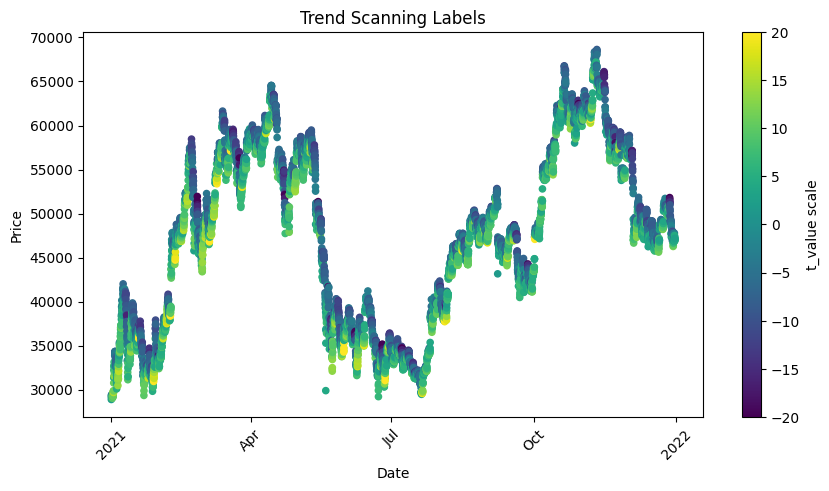

In [ ]:
fig = plt.figure(figsize=(10, 5))  # Increased width
scatter = plt.scatter(x=close_events.index, y=close_events.values, c=labels["tVal"], s=20)

# Adding a colorbar
plt.colorbar(scatter, label='t_value scale')

# Use a more sparse date locator and formatter
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate date labels for better visibility
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Trend Scanning Labels')
plt.show()

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1Tu6cclImG67wVc3OGIwji_GdePkJ9KUW"></center>

<center>👉👉 <a href="https://forms.gle/VAzqaLiUt4vfhc7P6">Take the Quiz here!</a>👈👈</center>



# Training a metamodel

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=12ddRAYYkip-CQ_RyjrHQPaTTp__tdqMS"></center>


## Getting the Data

---
<font color=green>Q5:</font> <br><font color='green'>
Load the training and test datasets from the data dictionary. Extract X_train, y_train, X_test, and y_test into separate variables for model training and evaluation.
**Expected:**
- Input: `data` dictionary containing preprocessed feature matrices and target variables
- Output: Four variables:
  - `X_train`: Training feature matrix (DataFrame/array)
  - `y_train`: Training target labels (Series/array)
  - `X_test`: Test feature matrix (DataFrame/array)
  - `y_test`: Test target labels (Series/array)
</font>

---

In [ ]:
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]

<center><img width="300" src = "https://drive.google.com/uc?export=view&id=1DiicygI-KldWU0s2_pI-xQX46Ld8l9l-"></center>


## Training Tree based Models and Neural Network

#### Bagging Algorithm:

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O2OQpFCPBysnNdl7iAp1f6PDfhhw21_t"></center>



---
<font color=green>Q6:</font> <br><font color='green'>
Train a Random Forest classifier using the training data with specific hyperparameters to prevent overfitting. Configure the model with 100 trees, maximum depth of 5, and entropy criterion for information gain.
**Expected:**
- Input: `X_train` (feature matrix) and `y_train` (target labels)
- Hyperparameters to set:
  - `n_estimators`: 100
  - `max_depth`: 5
  - `min_samples_split`: 5
  - `min_samples_leaf`: 2
  - `max_features`: 'sqrt'
  - `criterion`: 'entropy'
  - `random_state`: 42
  - `n_jobs`: -1 (use all processors)
- Output: Trained `rf_model` RandomForestClassifier instance
</font>

---

In [ ]:
# Train Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    criterion='entropy',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("✓ Random Forest trained successfully")


Training Random Forest...
✓ Random Forest trained successfully


#### Boosting Algorithm

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1Nq26CiGzznhcXxxid1Vz134zwNkEfsiK"></center>



---
<font color=green>Q7:</font> <br><font color='green'>
Train an XGBoost classifier with regularization parameters to prevent overfitting. Configure the model with 100 estimators, learning rate of 0.05, and both L1 and L2 regularization.
**Expected:**
- Input: `X_train` (feature matrix) and `y_train` (target labels)
- Hyperparameters to set:
  - `n_estimators`: 100
  - `max_depth`: 4
  - `learning_rate`: 0.05
  - `subsample`: 0.8
  - `colsample_bytree`: 0.8
  - `reg_alpha`: 0.1 (L1 regularization)
  - `reg_lambda`: 1.0 (L2 regularization)
  - `objective`: 'binary:logistic'
  - `eval_metric`: 'logloss'
  - `random_state`: 42
- Output: Trained `xgb_model` XGBClassifier instance
</font>

---

In [ ]:
print("\nTraining XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
print("✓ XGBoost trained successfully")


Training XGBoost...
✓ XGBoost trained successfully


#### Neural Networks for binary Classification

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1dpTroKYfGbC7rrejU-Goru4nbkbvlOkG"></center>


---
<font color=green>Q8:</font> <br><font color='green'>
Train a Multi-Layer Perceptron (Neural Network) classifier with two hidden layers and early stopping. Configure the network with 50 neurons in the first hidden layer and 30 in the second, using ReLU activation and Adam optimizer.
**Expected:**
- Input: `X_train` (feature matrix) and `y_train` (target labels)
- Architecture and hyperparameters to set:
  - `hidden_layer_sizes`: (50, 30) - two hidden layers
  - `activation`: 'relu'
  - `solver`: 'adam'
  - `alpha`: 0.01 (L2 regularization)
  - `batch_size`: 32
  - `learning_rate_init`: 0.001
  - `max_iter`: 500
  - `early_stopping`: True
  - `n_iter_no_change`: 20 (patience for early stopping)
  - `validation_fraction`: 0.1
  - `random_state`: 42
- Output: Trained `nn_model` MLPClassifier instance
</font>

---

In [ ]:
# Train Neural Network
print("\nTraining Neural Network...")
nn_model = MLPClassifier(
    hidden_layer_sizes=(50, 30),
    activation='relu',
    solver='adam',
    alpha=0.01,
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1,
    random_state=42
)
nn_model.fit(X_train, y_train)
print("✓ Neural Network trained successfully")


Training Neural Network...
✓ Neural Network trained successfully


---
<font color=green>Q9:</font> <br><font color='green'>
Create a dictionary to store all trained models for easy access and comparison. Map each model to a descriptive string key.
**Expected:**
- Input: Three trained model objects (`rf_model`, `xgb_model`, `nn_model`)
- Output: Dictionary `models` with keys:
  - 'Random Forest': rf_model instance
  - 'XGBoost': xgb_model instance
  - 'Neural Network': nn_model instance
</font>

---

In [ ]:
# Store all models
models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Neural Network': nn_model
}

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1Tu6cclImG67wVc3OGIwji_GdePkJ9KUW"></center>

<center>👉👉 <a href="https://forms.gle/n71WyEcjctQoaPLH9">Take the Quiz here!</a>👈👈</center>


## Feature Importance Analysis

#### Mean Decrease Impurity for Tree based Models

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1XGeatRzTRUqrqmoyoD2fApwuVsaAd05W"></center>

---
<font color=green>Q10:</font> <br><font color='green'>
Create a function that analyzes and visualizes Mean Decrease in Impurity (MDI) feature importance for tree-based models. The function should extract feature importances, rank them, and create a horizontal bar chart of the top features.
**Expected function: `plot_mdi_importance`**
- Input parameters:
  - `model`: A trained tree-based model (RandomForest or XGBoost) with `feature_importances_` attribute
  - `model_name`: String for the plot title
  - `n_features`: Integer specifying number of top features to display (default: 20)
- Process:
  - Extract feature importances from the model
  - Create DataFrame with feature names and importance scores
  - Sort by importance in descending order
  - Plot horizontal bar chart of top n features
- Output: DataFrame containing all features and their importance scores, sorted by importance
</font>

---

In [ ]:
def plot_mdi_importance(model, model_name, n_features=20):
    """Plot MDI feature importance for tree-based models"""
    mdi_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot top features
    plt.figure(figsize=(10, 8))
    top_features = mdi_importance.head(n_features)

    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title(f'{model_name} - Mean Decrease in Impurity (MDI)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return mdi_importance

---
<font color=green>Q11:</font> <br><font color='green'>
Apply the MDI feature importance analysis to the trained Random Forest model and visualize the results. Call the `plot_mdi_importance` function to display the top features identified by the Random Forest.
**Expected:**
- Input: `rf_model` (trained RandomForestClassifier) and model name string 'Random Forest'
- Output: Variable `rf_mdi` containing a DataFrame of all features sorted by importance
- Side effect: Displays a horizontal bar chart showing the top 20 most important features according to the Random Forest model
</font>

---


--- Random Forest Feature Importance (MDI) ---


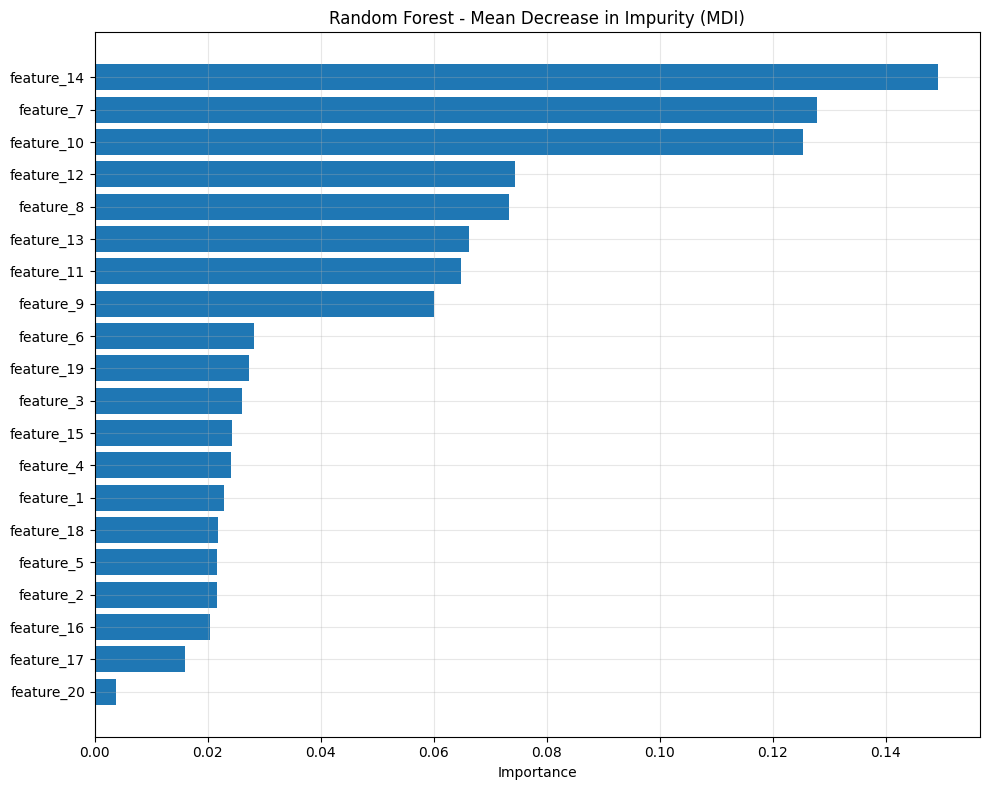

In [ ]:
# Feature importance for Random Forest (MDI)
print("\n--- Random Forest Feature Importance (MDI) ---")
rf_mdi = plot_mdi_importance(rf_model, 'Random Forest')

---
<font color=green>Q12:</font> <br><font color='green'>
Apply the MDI feature importance analysis to the trained XGBoost model and visualize the results. Call the `plot_mdi_importance` function to display the top features identified by XGBoost.
**Expected:**
- Input: `xgb_model` (trained XGBClassifier) and model name string 'XGBoost'
- Output: Variable `xgb_mdi` containing a DataFrame of all features sorted by importance
- Side effect: Displays a horizontal bar chart showing the top 20 most important features according to the XGBoost model
</font>

---


--- XGBoost Feature Importance (MDI) ---


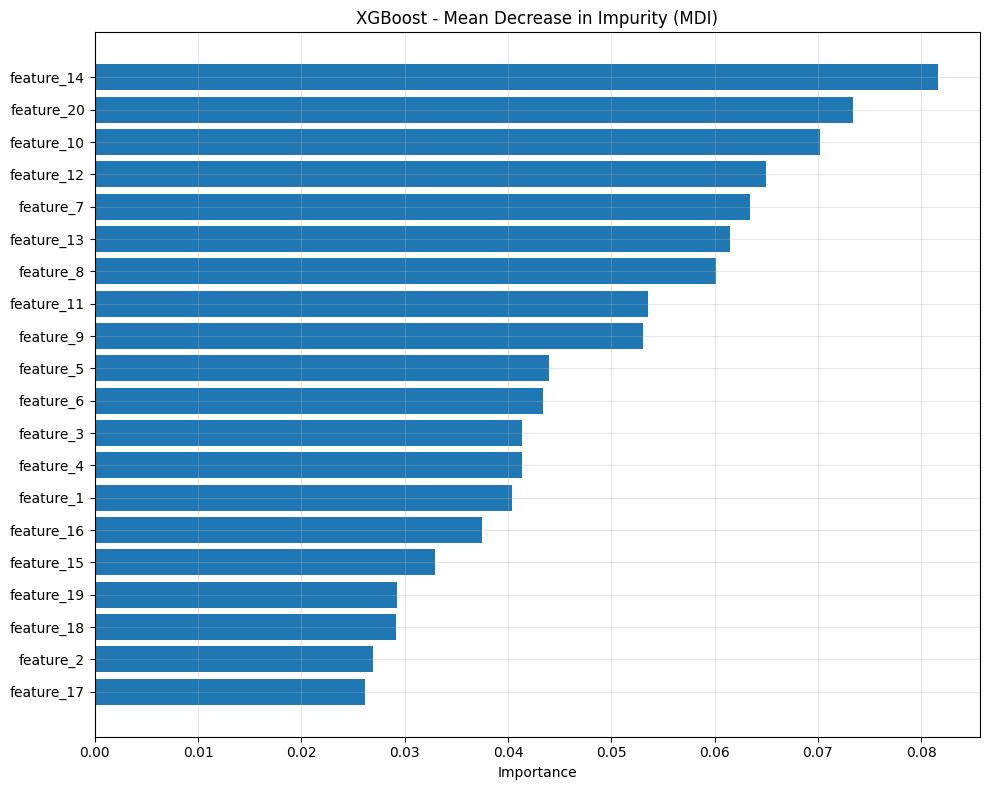

In [ ]:
# Feature importance for XGBoost (MDI)
print("\n--- XGBoost Feature Importance (MDI) ---")
xgb_mdi = plot_mdi_importance(xgb_model, 'XGBoost')

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/2C5zWGX2LoLoF9YN7">Click here to participate in the poll</a>👈👈</center>

#### Permutation Feature Importance for Neural Networks

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1iO33coloWYBP92VoaHK9cxL7NOGWm7V3"></center>

---
<font color=green>Q13:</font> <br><font color='green'>
Create a function that calculates and visualizes Permutation Feature Importance for any model. The function should compute importance scores by randomly shuffling each feature and measuring the decrease in model performance, then create a horizontal bar chart with error bars.
**Expected function: `plot_permutation_importance`**
- Input parameters:
  - `model`: Any trained classifier (works for all model types)
  - `model_name`: String for the plot title
  - `n_features`: Integer specifying number of top features to display (default: 20)
- Process:
  - Calculate permutation importance using test data
  - Use ROC-AUC as the scoring metric
  - Perform 10 permutation repeats for stability
  - Create DataFrame with mean importance and standard deviation
  - Sort by importance in descending order
  - Plot horizontal bar chart with error bars
- Output: DataFrame containing features with their mean importance scores and standard deviations
- Side effect: Displays a horizontal bar plot with error bars showing the top n most important features
- Uses global variables: `X_test`, `y_test`, `X_train` (for column names)
</font>

---

In [ ]:
def plot_permutation_importance(model, model_name, n_features=20):
    """Plot permutation feature importance"""
    perm_importance = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        scoring='roc_auc'
    )

    perm_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)

    # Plot top features
    plt.figure(figsize=(10, 8))
    top_features = perm_df.head(n_features)

    plt.barh(range(len(top_features)), top_features['importance'],
             xerr=top_features['std'], capsize=3)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title(f'{model_name} - Permutation Feature Importance')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return perm_df

---
<font color=green>Q14:</font> <br><font color='green'>
Apply the Permutation Feature Importance analysis to the trained Neural Network model and visualize the results. Call the `plot_permutation_importance` function to identify which features most impact the neural network's predictions.
**Expected:**
- Input: `nn_model` (trained MLPClassifier) and model name string 'Neural Network'
- Output: Variable `nn_perm` containing a DataFrame of all features with mean importance scores and standard deviations
- Side effect: Displays a horizontal bar chart with error bars showing the top 20 most important features according to permutation importance
</font>

---


--- Neural Network Feature Importance (Permutation) ---


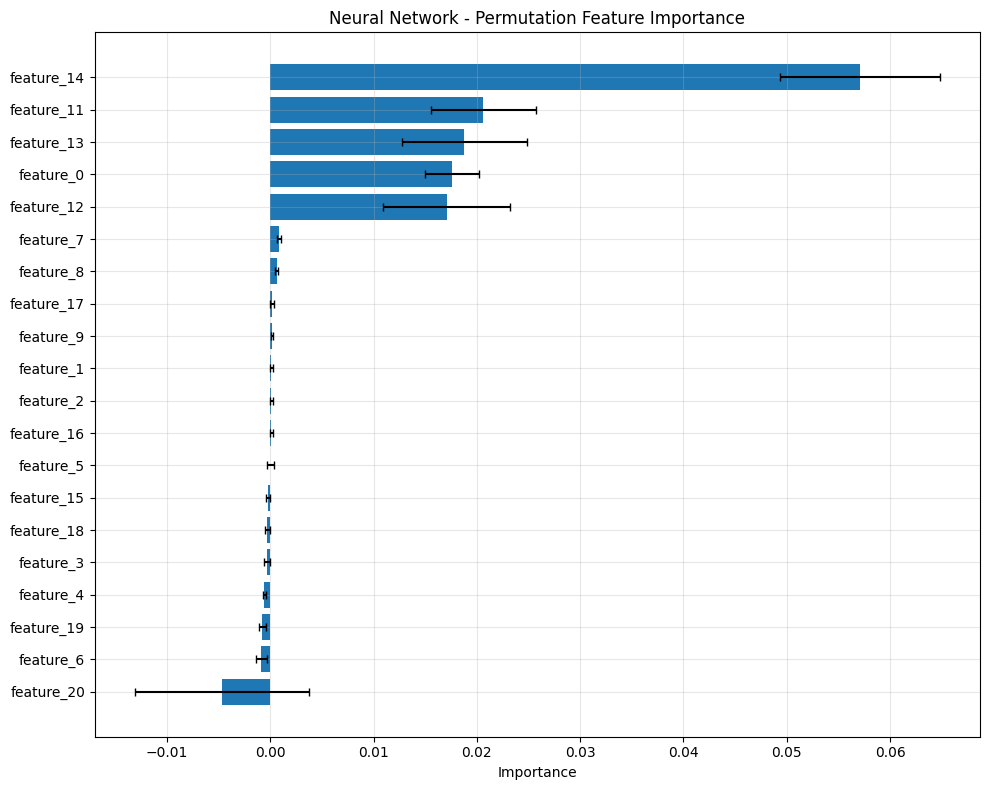

In [ ]:
# Feature importance for Neural Network (Permutation Feature Importance)
print("\n--- Neural Network Feature Importance (Permutation) ---")
nn_perm = plot_permutation_importance(nn_model, 'Neural Network')

---
<font color=green>Q15:</font> <br><font color='green'>
Create a nested dictionary to store all feature importance results from different models and methods. Organize the results by model name and importance calculation method.
**Expected:**
- Input: Three feature importance DataFrames (`rf_mdi`, `xgb_mdi`, `nn_perm`)
- Output: Dictionary `feature_importance_results` with structure:
  - 'Random Forest': nested dict with 'mdi' key containing rf_mdi DataFrame
  - 'XGBoost': nested dict with 'mdi' key containing xgb_mdi DataFrame  
  - 'Neural Network': nested dict with 'permutation' key containing nn_perm DataFrame
</font>

---

In [ ]:
# Store feature importance results
feature_importance_results = {
    'Random Forest': {'mdi': rf_mdi},
    'XGBoost': {'mdi': xgb_mdi},
    'Neural Network': {'permutation': nn_perm}
}

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1Tu6cclImG67wVc3OGIwji_GdePkJ9KUW"></center>

<center>👉👉 <a href="https://forms.gle/rBUxJaSVQZt1SdAx5">Take the Quiz here!</a>👈👈</center>


### Model Evaluation

---
<font color=green>Q16:</font> <br><font color='green'>
* Create a function that performs comprehensive evaluation of a classification model on both training and test sets. The function should calculate multiple performance metrics and store prediction probabilities for later analysis.
  **Expected function: `evaluate_model`**
  - Input parameters:
    - `model`: Trained classifier with `predict` and `predict_proba` methods
    - `X_train`: Training feature matrix
    - `y_train`: Training target labels
    - `X_test`: Test feature matrix
    - `y_test`: Test target labels
    - `model_name`: String identifier for the model
  - Process:
    - Generate predictions and probabilities for both train and test sets
    - Calculate classification metrics: accuracy, precision, recall, F1-score, AUC-ROC
    - Store all metrics in a dictionary
    - Include test probabilities for ROC curve plotting
  - Output: Dictionary containing:
    - 'Model': model name
    - All train/test metrics as key-value pairs
    - 'test_proba': array of test set prediction probabilities
  - Required imports: accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
* Evaluate all trained models using the comprehensive evaluation function. Iterate through the models dictionary, apply the evaluation function to each model, and collect the results in a list while displaying the test AUC score for each model.
  **Expected:**
  - Input: `models` dictionary containing all trained models, training and test data (X_train, y_train, X_test, y_test)
  - Process:
    - Loop through each model in the models dictionary
    - Call `evaluate_model` function for each model
    - Append results to `evaluation_results` list
    - Print the test AUC score for each model
  - Output: List `evaluation_results` containing evaluation metrics dictionaries for all models
  - Side effect: Prints evaluation progress and test AUC scores for each model
</font>

---

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Test Accuracy': accuracy_score(y_test, test_pred),
        'Train Precision': precision_score(y_train, train_pred),
        'Test Precision': precision_score(y_test, test_pred),
        'Train Recall': recall_score(y_train, train_pred),
        'Test Recall': recall_score(y_test, test_pred),
        'Train F1': f1_score(y_train, train_pred),
        'Test F1': f1_score(y_test, test_pred),
        'Train AUC': roc_auc_score(y_train, train_proba),
        'Test AUC': roc_auc_score(y_test, test_proba),
    }

    # Store predictions for ROC curve
    metrics['test_proba'] = test_proba

    return metrics

In [ ]:
# Evaluate all models
evaluation_results = []
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
    evaluation_results.append(metrics)
    print(f"{model_name} - Test AUC: {metrics['Test AUC']:.4f}")


Evaluating Random Forest...
Random Forest - Test AUC: 0.5417

Evaluating XGBoost...
XGBoost - Test AUC: 0.5379

Evaluating Neural Network...
Neural Network - Test AUC: 0.5649


<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/2C5zWGX2LoLoF9YN7">Click here to participate in the poll</a>👈👈</center>

---
<font color=green>Q17:</font> <br><font color='green'>
Create a comprehensive comparison table from the evaluation results and display key performance metrics for all models. Convert the evaluation results list into a DataFrame and show a subset of the most important test metrics.
**Expected:**
- Input: `evaluation_results` list containing metrics dictionaries for all models
- Process:
  - Convert the list of dictionaries into a pandas DataFrame
  - Select key metrics for display: Model name, Test Accuracy, Test F1, and Test AUC
  - Round values to 4 decimal places for readability
- Output:
  - `comparison_df`: DataFrame containing all evaluation metrics
  - Printed table showing selected test metrics for model comparison
</font>

---

In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame(evaluation_results)

# Display metrics comparison
print("\n=== MODEL PERFORMANCE COMPARISON ===")
display_metrics = ['Model', 'Test Accuracy', 'Test F1', 'Test AUC']
print(comparison_df[display_metrics].round(4))



=== MODEL PERFORMANCE COMPARISON ===
            Model  Test Accuracy  Test F1  Test AUC
0   Random Forest         0.5102   0.5293    0.5417
1         XGBoost         0.5057   0.5088    0.5379
2  Neural Network         0.5424   0.5525    0.5649


---
<font color=green>Q18:</font> <br><font color='green'>
Create ROC curves for all models on a single plot to compare their performance. Plot the true positive rate against the false positive rate for each model, include the random classifier baseline, and display AUC scores in the legend.
**Expected:**
- Input: `evaluation_results` list containing test probabilities and metrics, `y_test` for true labels
- Process:
  - Calculate ROC curve points (FPR, TPR) for each model using test probabilities
  - Plot each model's ROC curve with its AUC score in the legend
  - Add diagonal line representing random classifier performance
  - Configure plot with appropriate labels, title, grid, and legend
- Output: ROC curve visualization comparing all models' discriminative ability
- Required import: `roc_curve` from sklearn.metrics
</font>

---

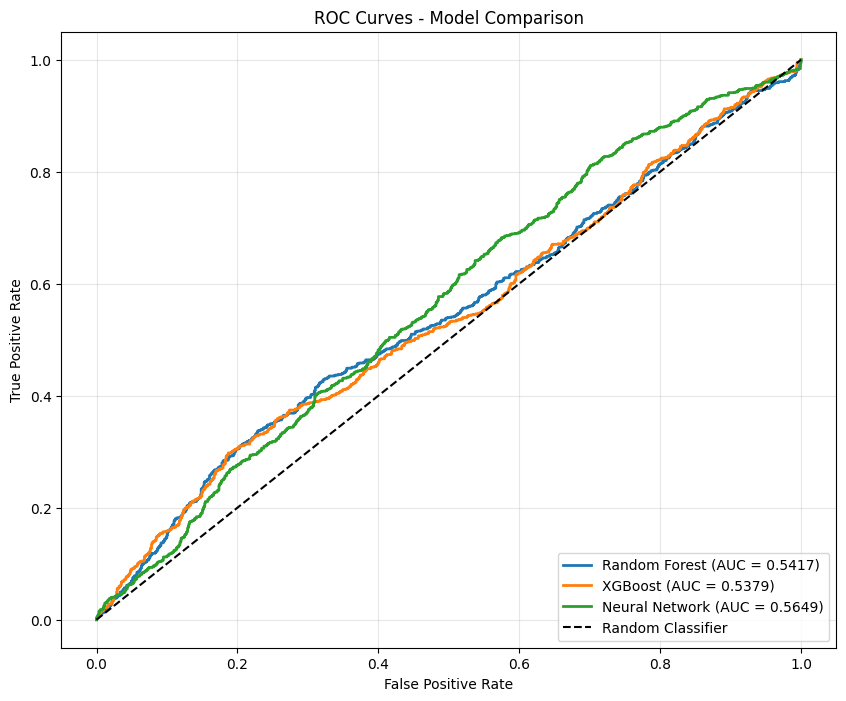

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for result in evaluation_results:
    fpr, tpr, _ = roc_curve(y_test, result['test_proba'])
    plt.plot(fpr, tpr, linewidth=2,
            label=f"{result['Model']} (AUC = {result['Test AUC']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/2C5zWGX2LoLoF9YN7">Click here to participate in the poll</a>👈👈</center>

---
<font color=green>Q19:</font> <br><font color='green'>
Create a grouped bar chart to visualize and compare multiple performance metrics across all models. Display test accuracy, F1-score, and AUC side by side for each model to facilitate direct comparison.
**Expected:**
- Input: `comparison_df` DataFrame containing evaluation metrics for all models
- Process:
  - Select three key test metrics: Accuracy, F1, and AUC
  - Create grouped bars with each model having its own bar color
- Output: Grouped bar chart showing comparative performance across models and metrics
</font>

---

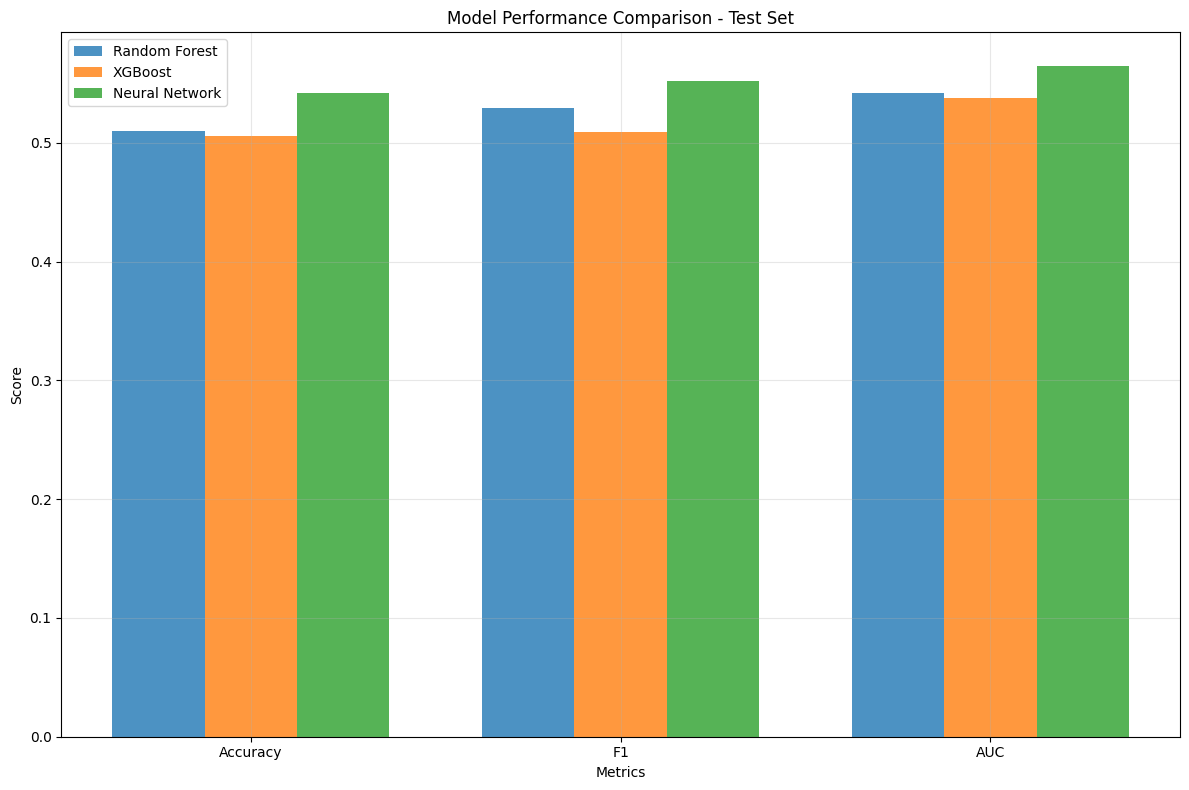

In [ ]:
# Plot metrics comparison
metrics_to_plot = ['Test Accuracy', 'Test F1', 'Test AUC']
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (_, row) in enumerate(comparison_df.iterrows()):
    values = [row[metric] for metric in metrics_to_plot]
    ax.bar(x + i*width, values, width, label=row['Model'], alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison - Test Set')
ax.set_xticks(x + width)
ax.set_xticklabels([m.replace('Test ', '') for m in metrics_to_plot])
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
<font color=green>Q20:</font> <br><font color='green'>
Identify the best performing model based on test AUC score and create a comprehensive results dictionary for saving. Extract the model with the highest test AUC, display all its performance metrics, and prepare all results for persistence.
**Expected:**
- Input: `comparison_df` with model metrics, `models` dictionary with trained models
- Process:
  - Find index of model with maximum test AUC using `idxmax()`
  - Extract model name and retrieve the actual model object
  - Print comprehensive performance summary of the best model
  - Create a dictionary containing all training artifacts
- Output:
  - `best_model`: The model object with highest test AUC
  - `best_model_name`: String identifier of best model
  - `save_dict`: Dictionary containing:
    - best_model and its name
    - all trained models
    - comparison table
    - feature importance results
    - raw evaluation results
- Side effect: Prints detailed performance metrics of the best model
</font>

---

In [ ]:
# Find best model
best_model_idx = comparison_df['Test AUC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model = models[best_model_name]


print(f"\n=== BEST MODEL: {best_model_name} ===")
print(f"Test AUC: {comparison_df.loc[best_model_idx, 'Test AUC']:.4f}")
print(f"Test Accuracy: {comparison_df.loc[best_model_idx, 'Test Accuracy']:.4f}")
print(f"Test F1: {comparison_df.loc[best_model_idx, 'Test F1']:.4f}")
print(f"Test Precision: {comparison_df.loc[best_model_idx, 'Test Precision']:.4f}")
print(f"Test Recall: {comparison_df.loc[best_model_idx, 'Test Recall']:.4f}")


save_dict = {
    'best_model': best_model,
    'best_model_name': best_model_name,
    'all_models': models,
    'comparison_table': comparison_df,
    'feature_importance': feature_importance_results,
    'evaluation_results': evaluation_results
}


=== BEST MODEL: Neural Network ===
Test AUC: 0.5649
Test Accuracy: 0.5424
Test F1: 0.5525
Test Precision: 0.5145
Test Recall: 0.5966


<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/2C5zWGX2LoLoF9YN7">Click here to participate in the poll</a>👈👈</center>

---
### Conclusion

In this programming session, we implemented the Trend Scanning Method for labeling Bitcoin price data and developed a metamodel framework for systematic trading. The work comprised:

**Trend Scanning Implementation**: We created functions to identify price trends by calculating t-values across multiple time windows (5-20 periods). The method selects the window with the highest absolute t-value for each time point, generating labels that indicate trend direction and strength.

**Metamodel Development**: We trained three classifiers (Random Forest, XGBoost, and Neural Network) using market microstructure features including momentum indicators, volatility measures, and autocorrelation values. The models showed test AUC scores around 0.56-0.57, indicating modest predictive ability above random chance.

**Feature Importance Analysis**: We applied MDI for tree-based models and Permutation Importance for the neural network to identify influential features. This analysis showed which market conditions have the strongest relationship with model predictions.

**Model Evaluation**: We compared models using multiple metrics (accuracy, precision, recall, F1-score, AUC) and visualized performance through ROC curves and bar charts. The evaluation revealed similar performance across all three model types.

---
### Future Exploration

To extend this framework, consider:

* **Primary Model Development**: Build a model trained on trend scanning labels using:
- Technical indicators and price-based features
- Market regime indicators
- Volume and volatility features
- Cross-timeframe features

* Then develop a metamodel to filter the primary model's predictions based on market conditions

* **Hyperparameter Optimization**: Apply systematic tuning methods to improve model performance (see Programming Session 4)

* **Clustered Feature Importance Analysis**: Group related features to understand collective influences on predictions (see Programming Session 2)

* **Alternative Neural Network Architectures**: Test different configurations including recurrent layers, attention mechanisms, and various regularization techniques

These extensions would create a more complete trading system from signal generation to trade filtering.

### Contact

If you have any question regarding this notebook, do not hesitate to contact: h.madmoun@imperial.ac.uk